In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests    
from scipy import stats
import os
%matplotlib inline



In [83]:
try:
    with open("airquality-config.json") as f:                 
        data = json.load(f)
        webcom_database = data['webcom_database']
        location = data['location']
        timezone = data['timezone']
except:
    print("###")
    print("###")
    print("###")
    print('### to run the notebook locally, setup an airquality-config.json file from the example')
    print("###")
    print("###")
    print("###")

print("configuration loaded")  

configuration loaded


In [21]:
try:
    secrets_path=secretsPath
except:
    secrets_path='airquality-secrets.json'

print("loading secrets from "+secrets_path)    

loading secrets from airquality-secrets.json


In [84]:
    
try:
    with open(secrets_path) as f:                 
        data = json.load(f)
        webcom_key = data['webcom_key']
except:
    print("###")
    print("###")
    print("###")
    print('### to run the notebook locally, setup an '+secrets_path+' file from the example')
    print("###")
    print("###")
    print("###")

print("secrets loaded")    

secrets loaded


In [23]:
print("running with the following parameters:")
print("- webcom_database: "+webcom_database)    
print("- location: "+location)    
print("- webcom_key (length): "+str(len(webcom_key)))


running with the following parameters:
- webcom_database: airquality
- location: juvisy
- webcom_key (length): 40


In [24]:

r = requests.get('https://io.datasync.orange.com/datasync/v2/'+webcom_database+'/data/'+location, 
                 headers={"content-type":"application/json", 
                          "Authorization": "Bearer "+webcom_key})
json_content = r.json()
#print(json.dumps(json_content, indent=2))
print ("size of the loaded json: " +str(len(json.dumps(json_content))/1024) +"K")



size of the loaded json: 31.09375K


In [68]:
data = []
for year in json_content:
    #print(year)
    for month in json_content[year]:
        #print(month)
        for day in json_content[year][month]:
            #print(day)
            for measure in json_content[year][month][day]:
                #print(measure)
                data.append( json_content[year][month][day][measure])

data = sorted(data, key=lambda d: d['ts'])    
#print(json.dumps(data, indent=2))
print(pd.DataFrame(data).tail())

     pm_10_0  pm_1_0  pm_2_5             ts
351       10       6       9  1587822553494
352       10       6       9  1587823213385
353        9       5       9  1587823872995
354        9       5       7  1587824532992
355        9       6       8  1587825192979


In [70]:

#df = pd.read_json( json.dumps(json_content), orient='index', convert_dates=['ts'], date_unit='ms')
df = pd.read_json( json.dumps(data),  convert_dates=['ts'], date_unit='ms')
#df.ts = df.index.tz_localize('GMT')
#df.ts.dt.tz_localize('GMT').tz_convert('America/New_York')


df = df.set_index('ts')
df.index = df.index.tz_localize('UTC').tz_convert(timezone)

print(df.tail())


                                  pm_10_0  pm_1_0  pm_2_5
ts                                                       
2020-04-25 15:49:13.494000+02:00       10       6       9
2020-04-25 16:00:13.385000+02:00       10       6       9
2020-04-25 16:11:12.995000+02:00        9       5       9
2020-04-25 16:22:12.992000+02:00        9       5       7
2020-04-25 16:33:12.979000+02:00        9       6       8


In [73]:
df.pm_2_5.tail(10).mean()

8.7

In [74]:
stats.gmean(df.pm_2_5.tail(10))

8.652344519566356

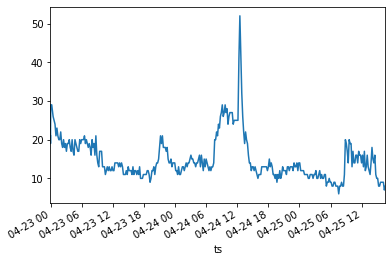

In [75]:
#df.groupby([df.ts.dt.strftime('%y%m%d %H:%M')])
df.pm_2_5.plot(kind='line')

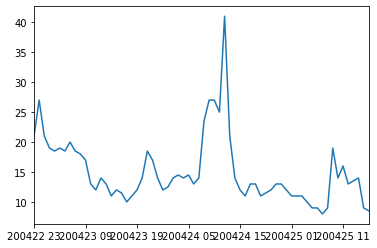

In [76]:
df.groupby([df.index.strftime('%y%m%d %H')]).pm_2_5.median().plot()

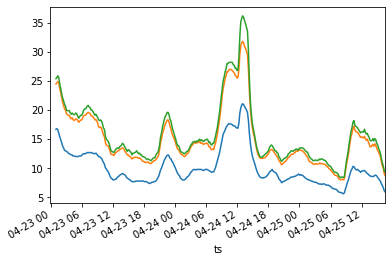

In [77]:
df.pm_1_0.rolling(10).mean().plot()
df.pm_2_5.rolling(10).mean().plot()
df.pm_10_0.rolling(10).mean().plot()


In [78]:
import altair as alt 

alt.Chart(df.reset_index()).mark_line().encode(
    x='ts:T',
    y='pm_1_0:Q',    
).interactive()

alt.Chart(...)

In [79]:
long_form=df.reset_index().melt('ts', var_name='particle', value_name='value')

alt.Chart(long_form).mark_line().encode(
  x='ts:T',
  y='value:Q',
  color='particle:N'
).interactive()


alt.Chart(...)

In [80]:
import tempfile

#alt.data_transformers.enable('json')

long_form=df.reset_index().melt('ts', var_name='particle', value_name='value')

data=long_form

url = 'data-'+location+'.json'
data.to_json(url, orient='records')

click = alt.selection_multi(encodings=['color'])


line = alt.Chart(url).mark_line().encode(
  x='ts:T',
  y='value:Q',
  color='particle:N',
  size=alt.value(3),
).transform_window(
    moving_avg='mean(value)',
    frame=[-3, 2],
    sort=[alt.SortField("ts","ascending")],
    groupby=['particle']
).encode(
    x='ts:T',
    y='moving_avg:Q'
).transform_filter(
    click
).interactive() 

points = alt.Chart(url).mark_point().encode(
    #x='ts:T',
    alt.X('ts:T', title='@'+location),    
    y=alt.Y('value:Q',
            axis=alt.Axis(title='particle count')),
    color='particle:N',
    size=alt.value(1),
    tooltip=['monthdate(ts):T','hoursminutes(ts):T','particle:N','value:Q'],
).properties(
    width=800,
    height=500
).transform_filter(
    click
).interactive()

legend = alt.Chart(url).mark_rect().encode(
    y=alt.Y('particle:N', axis=alt.Axis(title='Particle type')),
    color=alt.condition(click, 'particle:N', 
                        alt.value('lightgray'), legend=None),
    size=alt.value(250)
).properties(
    selection=click
)

chart = (points + line) | legend


try:
    output_dir = os.environ['GITHUB_WORKSPACE'] + '/output'
except KeyError:
    output_dir = tempfile.gettempdir()+'/jupyter/airquality'    

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('saving chart in '+output_dir)        


data.to_json(output_dir+'/'+url, orient='records')
chart.save(output_dir+'/airquality-'+location+'.html') 

chart

saving chart in /tmp/user/1000/jupyter/airquality


alt.HConcatChart(...)